In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.comparison_tools import dataset_statistics
from pyqg_generative.tools.simulate import run_simulation
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# advect function from operators module

In [87]:
import pyqg_generative.tools.operators as op 

In [752]:
m = pyqg.QGModel()
filtr = np.array(pyqg.QGModel(filterfac=1e+20).filtr)

INFO:  Logger initialized
INFO:  Logger initialized


In [789]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/0.nc', decode_times=False)
lap = (m.ik)**2 + (m.il)**2
q = dss.q.isel(time=-1).values.astype('float64')
m.q = q#m.ifft(lap * m.fft(q))
m._invert()
np.linalg.norm(q-m.q)

0.0

In [1]:
import xrft
sp = lambda x: xrft.isotropic_power_spectrum(xr.DataArray(x)).plot(xscale='log', yscale='log', marker='o')
csp = lambda x,y: np.real(xrft.isotropic_cross_spectrum(xr.DataArray(x), xr.DataArray(y))).plot(xscale='log', marker='o')

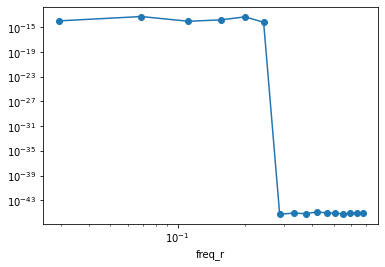

In [869]:
sp(m.q[0])

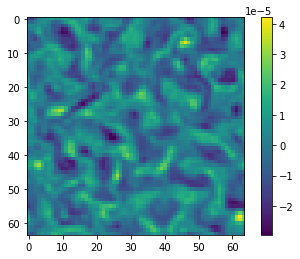

In [792]:
plt.imshow(m.q[0]);plt.colorbar()

### Without dealiasing

In [793]:
def test_PV(dqdt):
    return dqdt.mean(axis=(-2,-1)) / dqdt.std(axis=(-2,-1))

def test_Ens(dqdt,q):
    '''
    Returns timescale on which enstrophy will be changed
    in days
    '''
    return (q*dqdt).mean(axis=(-2,-1)) / (q.std(axis=(-2,-1)) * dqdt.std(axis=(-2,-1)))

def test_En(dqdt,psi):
    return (psi*dqdt).mean(axis=(-2,-1)) / (psi.std(axis=(-2,-1)) * dqdt.std(axis=(-2,-1)))

In [794]:
q = m.q
psi = m.ifft(m.ph)
u = m.u
v = m.v
dqdt = op.advect(q,u,v)
dqdt_two_thirds = op.advect(q,u,v,dealias='2/3-rule')
dqdt_three_second= op.advect(q,u,v,dealias='3/2-rule')

In [795]:
print(test_PV(dqdt))
print(test_PV(dqdt_two_thirds))
print(test_PV(dqdt_three_second))

[-4.99507412e-19 -2.92766947e-18]
[ 7.34534196e-18 -3.07244017e-18]
[-5.57715856e-19  2.34988861e-18]


In [796]:
print(test_Ens(dqdt,q))
print(test_Ens(dqdt_two_thirds,q))
print(test_Ens(dqdt_three_second,q))

[-2.47353362e-05  1.14621001e-05]
[-2.74793201e-17  2.37174341e-18]
[1.61019131e-17 8.61638615e-18]


In [797]:
print(test_En(dqdt,psi))
print(test_En(dqdt_two_thirds,psi))
print(test_En(dqdt_three_second,psi))

[0.00000000e+00 6.30075276e-18]
[ 1.91668452e-17 -1.10205325e-17]
[-2.53095115e-17 -7.02401086e-18]


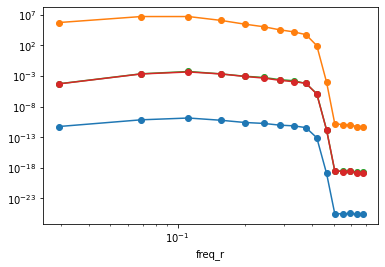

In [798]:
sp(q[0])
sp(psi[0])
sp(u[0])
sp(v[0])

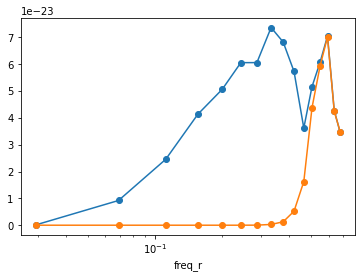

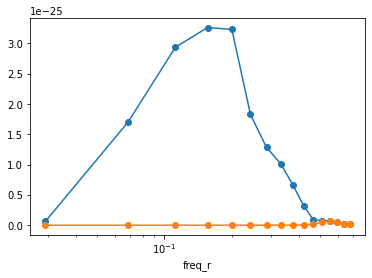

In [805]:
plt.figure()
sp(dqdt[0])
#sp(dqdt_two_thirds[0])
sp(dqdt_three_second[0]-dqdt[0])
plt.yscale('linear')

plt.figure()
sp(dqdt[1])
#sp(dqdt_two_thirds[1])
sp(dqdt_three_second[1]-dqdt[1])
#plt.ylim([1e-28,1e-22])
plt.yscale('linear')

# FFT regridding on test functions

In [812]:
[X,Y] = np.meshgrid(np.linspace(0,2*np.pi,17)[:-1], np.linspace(0,2*np.pi,17)[:-1])
[Xt,Yt] = np.meshgrid(np.linspace(0,2*np.pi,25)[:-1], np.linspace(0,2*np.pi,25)[:-1])
[Xtt,Ytt] = np.meshgrid(np.linspace(0,2*np.pi,9)[:-1], np.linspace(0,2*np.pi,9)[:-1])
Z = np.cos(1*X) * np.sin(1*Y)
Zt = np.cos(1*Xt) * np.sin(1*Yt)
Ztt = np.cos(1*Xtt) * np.sin(1*Ytt)

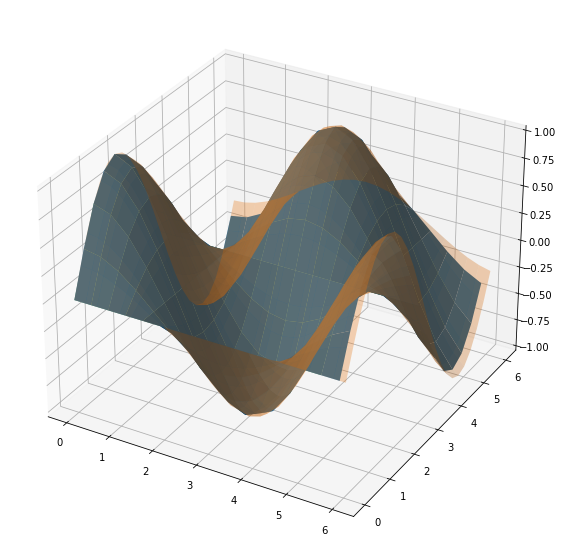

In [813]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.plot_surface(Xt, Yt, Zt, alpha=0.3)
ax.plot_surface(Xtt, Ytt, Ztt, alpha=0.5)

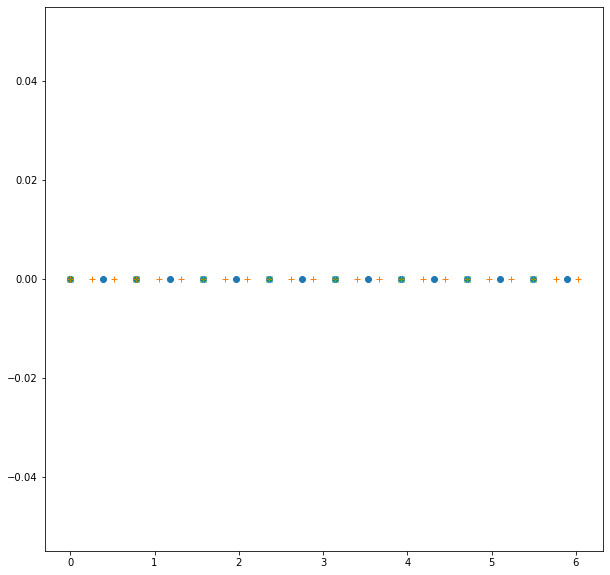

In [814]:
plt.figure(figsize=(10,10))
plt.plot(X[0],Z[0],'o')
plt.plot(Xt[0],Zt[0],'+')
plt.plot(Xtt[0],Ztt[0],'x')

In [815]:
x = np.random.randn(4,4)
np.linalg.norm(x-op.fft_interpolate(x,4,4))

2.719791912321612

In [818]:
np.linalg.norm(Zt-op.fft_interpolate(Z,16,24))

7.807311853781127e-15

In [819]:
np.linalg.norm(Ztt-op.fft_interpolate(Z,16,8))

1.1633258978803383e-15

In [820]:
np.linalg.norm(np.stack([Z,Z])-np.stack([op.fft_interpolate(Z,16,16),op.fft_interpolate(Z,16,16)]))

1.956802269106906e-15

In [821]:
np.linalg.norm(np.stack([Zt,Zt])-np.stack([op.fft_interpolate(Z,16,24),op.fft_interpolate(Z,16,24)]))

1.1041206309293501e-14

In [822]:
np.linalg.norm(np.stack([Ztt,Ztt])-np.stack([op.fft_interpolate(Z,16,8),op.fft_interpolate(Z,16,8)]))

1.6451912622422328e-15

In [823]:
x = np.random.randn(64,64)
np.linalg.norm(op.cut_off(x,16) - op.fft_interpolate(x,64,16))

0.0

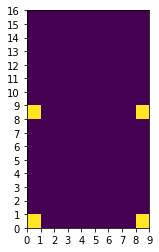

In [824]:
plt.pcolormesh(np.abs(np.imag(np.fft.rfftn(np.random.randn(16,16))))<1e-4, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(0,10,1));
plt.yticks(np.arange(0,17,1));

# Check commutation with differentiation

In [825]:
m = pyqg.QGModel()
mc = pyqg.QGModel(nx=8)

INFO:  Logger initialized
INFO:  Logger initialized


In [826]:
u = np.random.randn(2,64,64)
v = np.random.randn(2,64,64)

In [827]:
div_coarse_uv = op.fft_interpolate(m.ifft(m.ik*m.fft(u)+m.il*m.fft(v)), 64, 8)
uc = op.fft_interpolate(u,64,8)
vc = op.fft_interpolate(v,64,8)
coarse_div_uv = mc.ifft(mc.ik*mc.fft(uc)+mc.il*mc.fft(vc))

np.linalg.norm(div_coarse_uv-coarse_div_uv)

5.680185893437048e-20

In [828]:
div_coarse_uv = op.cut_off(m.ifft(m.ik*m.fft(u)+m.il*m.fft(v)), 8)
uc = op.cut_off(u,8)
vc = op.cut_off(v,8)
coarse_div_uv = mc.ifft(mc.ik*mc.fft(uc)+mc.il*mc.fft(vc))

np.linalg.norm(div_coarse_uv-coarse_div_uv)

5.680185893437048e-20

# Check that truncation does not affect low frequencies

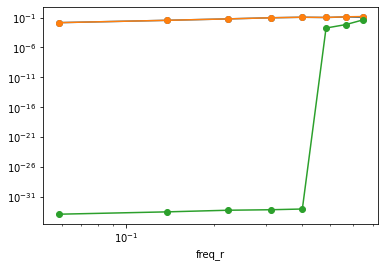

In [593]:
sp(op.fft_interpolate(u[0],64,32))
sp(op.fft_interpolate(u[0],64,32,truncate_2h=False))
sp(op.fft_interpolate(u[0],64,32)-op.fft_interpolate(u[0],64,32,truncate_2h=False))

# Check new subgrid forcing function

In [989]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [990]:
q = dss.q.isel(time=-1,run=0).values

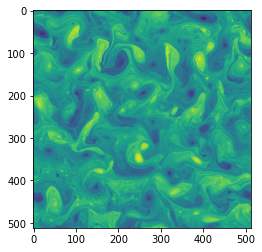

In [991]:
plt.imshow(q[0])

In [992]:
forcing_op1, m_op1, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS)
forcing_op2, m_op2, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS)
forcing_op5, m_op5, _ = op.PV_subgrid_forcing(q, 48, op.Operator5, EDDY_PARAMS)
forcing_32, m_32, _ = op.PV_subgrid_forcing(q, 48, op.Operator5, EDDY_PARAMS, '3/2-rule')

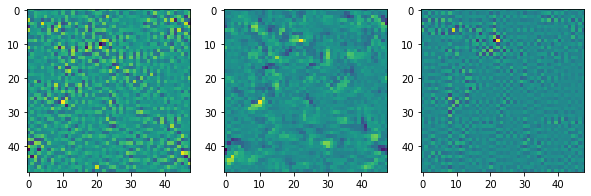

In [994]:
lev=1
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(forcing_op1[lev])
plt.subplot(1,3,2)
plt.imshow(forcing_op2[lev])
plt.subplot(1,3,3)
plt.imshow(forcing_32[lev])

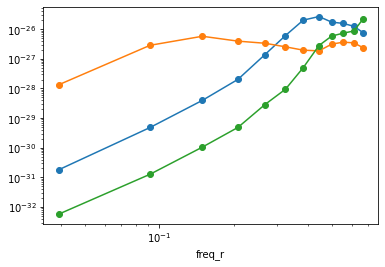

In [995]:
lev=1
sp(forcing_op1[lev])
sp(forcing_op2[lev])
sp(forcing_32[lev])

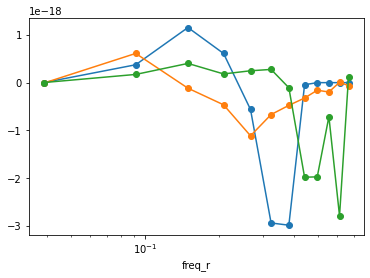

In [996]:
lev=0
csp(forcing_op1[lev], m_op1.q[lev])
csp(forcing_op2[lev], m_op2.q[lev])
csp(forcing_32[lev], m_32.q[lev])

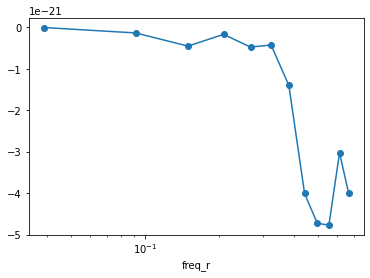

In [997]:
csp(forcing_32[1], m_32.q[1])

# Check that subgrid forcing + coarse advection = fine advection

In [6]:
import pyqg_generative.tools.operators as op

In [2]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-1].nc', concat_dim='run', combine='nested', decode_times=False)

In [7]:
q = dss.q.isel(time=-1,run=0).values

In [16]:
SGS, mf, m = op.PV_subgrid_forcing(q, 64, op.Operator5, EDDY_PARAMS,'3/2-rule')
mf.dealiasing='3/2-rule'

In [17]:
advf = - op.advect(mf.q, mf.u, mf.v, dealias='3/2-rule') # minus to move to RHS
adv_pyqg = mf.ifft(-mf._advect(mf.q))
adv_full = SGS + advf
adv = - op.cut_off(op.advect(m.q,m.u,m.v,dealias='3/2-rule'),64)

In [18]:
np.linalg.norm(adv-adv_full) / np.linalg.norm(adv)

1.477713769099094e-17

In [19]:
np.linalg.norm(adv-(SGS+adv_pyqg)) / np.linalg.norm(adv)

6.572578832342283e-16

# Did you try to remove aliasing error from subgrid forcing?

In [998]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [999]:
q = dss.q.isel(time=-1,run=0).values

In [1005]:
forcing_op1, m_op1, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS)
forcing_op2, m_op2, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS)

forcing_op1_alias, m_op1_alias, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS, '3/2-rule')
forcing_op2_alias, m_op2_alias, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS, '3/2-rule')

Text(0.5, 1.0, 'Sharp filter')

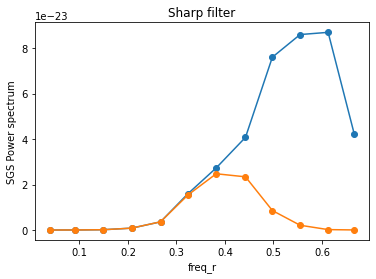

In [1010]:
sp(forcing_op1[0])
sp(forcing_op1_alias[0])
plt.xscale('linear')
plt.yscale('linear')
plt.ylabel('SGS Power spectrum')
plt.title('Sharp filter')

Text(0.5, 1.0, 'Gaussian filter')

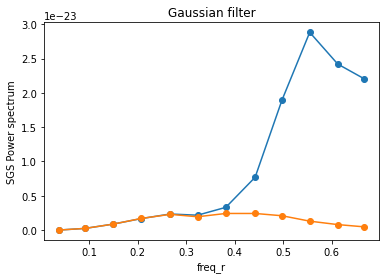

In [1012]:
sp(forcing_op2[0])
sp(forcing_op2_alias[0])
plt.xscale('linear')
plt.yscale('linear')
plt.ylabel('SGS Power spectrum')
plt.title('Gaussian filter')

# Implement 3/2-dealiasing to the pyqg model

In [20]:
q0 = np.random.randn(2,64,64)

In [21]:
m = pyqg.QGModel(); m.q = q0.copy(); m._invert()
m._do_advection()
dqdt = m.dqhdt.copy()

INFO:  Logger initialized


In [22]:
m = pyqg.QGModel(); m.q = q0.copy(); m._invert()
m.dealiasing='None'
dqdt_new = - m._advect(m.q) - m._do_background_flow()
m.dealiasing='3/2-rule'
dqdt_alias = - m._advect(m.q) - m._do_background_flow()
#dqdt_new = m.dqhdt.copy()

INFO:  Logger initialized


In [23]:
np.linalg.norm(dqdt-dqdt_new) / np.linalg.norm(dqdt)

1.5794133387008846e-16

In [24]:
np.linalg.norm(dqdt-dqdt_alias) / np.linalg.norm(dqdt)

0.6900122697910133

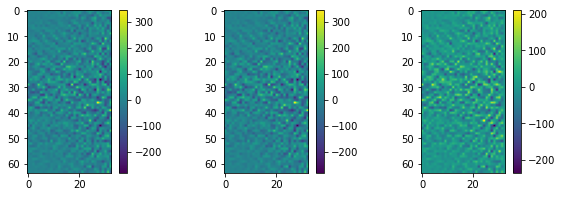

In [109]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(np.real(dqdt[0])); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.real(dqdt_new[0]));plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.real(dqdt_alias[0]));plt.colorbar()

In [118]:
m.wv2.shape

(256, 129)

# Test dealiased model

INFO:  Logger initialized


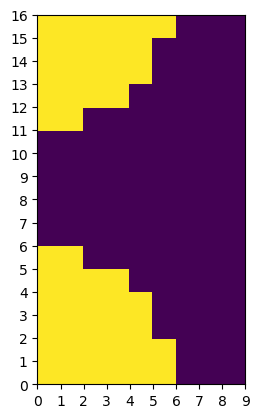

In [25]:
plt.pcolor(pyqg.QGModel(nx=16,filterfac=1e+20).filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

INFO:  Logger initialized


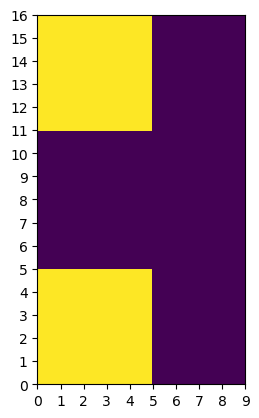

In [26]:
plt.pcolor(pyqg.QGModel(nx=16,dealiasing='2/3-rule').filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

INFO:  Logger initialized


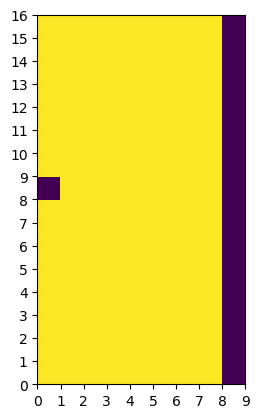

In [27]:
plt.pcolor(pyqg.QGModel(nx=16,dealiasing='3/2-rule').filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

In [34]:
exp = run_simulation(EDDY_PARAMS._update({'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 1.12e-06, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 6.39e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 4.38e-05, CFL: 0.046
INFO: Step: 4000, Time years:  1.9, KE: 3.10e-04, CFL: 0.130
INFO: Step: 5000, Time years:  2.3, KE: 4.73e-04, CFL: 0.192
INFO: Step: 6000, Time years:  2.8, KE: 4.66e-04, CFL: 0.184
INFO: Step: 7000, Time years:  3.2, KE: 4.83e-04, CFL: 0.218
INFO: Step: 8000, Time years:  3.7, KE: 4.72e-04, CFL: 0.173
INFO: Step: 9000, Time years:  4.2, KE: 5.15e-04, CFL: 0.206
INFO: Step: 10000, Time years:  4.6, KE: 4.98e-04, CFL: 0.188
INFO: Step: 11000, Time years:  5.1, KE: 5.40e-04, CFL: 0.259
INFO: Step: 12000, Time years:  5.6, KE: 4.87e-04, CFL: 0.203
INFO: Step: 13000, Time years:  6.0, KE: 5.15e-04, CFL: 0.198
INFO: Step: 14000, Time years:  6.5, KE: 5.22e-04, CFL: 0.210
INFO: Step: 15000, Time years:  6.9, KE: 4.60e-04, CFL: 0.192
INFO: Step: 16000, Time years:  7.4, KE: 4.74e-04, CF

Function 'run_simulation' executed in 42.3734s


In [35]:
two_thirds_lazy = run_simulation(EDDY_PARAMS._update({'filterfac': 1e+20, 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 7.57e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 4.69e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 3.48e-05, CFL: 0.034
INFO: Step: 4000, Time years:  1.9, KE: 2.78e-04, CFL: 0.098
INFO: Step: 5000, Time years:  2.3, KE: 5.98e-04, CFL: 0.185
INFO: Step: 6000, Time years:  2.8, KE: 7.10e-04, CFL: 0.208
INFO: Step: 7000, Time years:  3.2, KE: 7.04e-04, CFL: 0.205
INFO: Step: 8000, Time years:  3.7, KE: 6.54e-04, CFL: 0.230
INFO: Step: 9000, Time years:  4.2, KE: 6.35e-04, CFL: 0.206
INFO: Step: 10000, Time years:  4.6, KE: 6.36e-04, CFL: 0.199
INFO: Step: 11000, Time years:  5.1, KE: 6.48e-04, CFL: 0.214
INFO: Step: 12000, Time years:  5.6, KE: 6.66e-04, CFL: 0.253
INFO: Step: 13000, Time years:  6.0, KE: 6.84e-04, CFL: 0.204
INFO: Step: 14000, Time years:  6.5, KE: 7.04e-04, CFL: 0.216
INFO: Step: 15000, Time years:  6.9, KE: 7.28e-04, CFL: 0.212
INFO: Step: 16000, Time years:  7.4, KE: 7.54e-04, CF

Function 'run_simulation' executed in 41.9415s


In [36]:
two_thirds = run_simulation(EDDY_PARAMS._update({'dealiasing': '2/3-rule', 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 3.56e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 1.33e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 7.21e-06, CFL: 0.024
INFO: Step: 4000, Time years:  1.9, KE: 4.86e-05, CFL: 0.057
INFO: Step: 5000, Time years:  2.3, KE: 1.85e-04, CFL: 0.131
INFO: Step: 6000, Time years:  2.8, KE: 3.99e-04, CFL: 0.176
INFO: Step: 7000, Time years:  3.2, KE: 5.21e-04, CFL: 0.183
INFO: Step: 8000, Time years:  3.7, KE: 5.84e-04, CFL: 0.197
INFO: Step: 9000, Time years:  4.2, KE: 5.97e-04, CFL: 0.197
INFO: Step: 10000, Time years:  4.6, KE: 5.53e-04, CFL: 0.195
INFO: Step: 11000, Time years:  5.1, KE: 5.07e-04, CFL: 0.186
INFO: Step: 12000, Time years:  5.6, KE: 4.69e-04, CFL: 0.186
INFO: Step: 13000, Time years:  6.0, KE: 4.45e-04, CFL: 0.180
INFO: Step: 14000, Time years:  6.5, KE: 4.31e-04, CFL: 0.175
INFO: Step: 15000, Time years:  6.9, KE: 4.24e-04, CFL: 0.155
INFO: Step: 16000, Time years:  7.4, KE: 4.23e-04, CF

Function 'run_simulation' executed in 41.8412s


In [28]:
three_second_40 = run_simulation(EDDY_PARAMS._update({'dealiasing': '3/2-rule', 'nx': 40, 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 6.80e-07, CFL: 0.015
INFO: Step: 2000, Time years:  0.9, KE: 2.84e-06, CFL: 0.015
INFO: Step: 3000, Time years:  1.4, KE: 1.62e-05, CFL: 0.019
INFO: Step: 4000, Time years:  1.9, KE: 1.10e-04, CFL: 0.048
INFO: Step: 5000, Time years:  2.3, KE: 2.96e-04, CFL: 0.091
INFO: Step: 6000, Time years:  2.8, KE: 4.18e-04, CFL: 0.109
INFO: Step: 7000, Time years:  3.2, KE: 4.98e-04, CFL: 0.100
INFO: Step: 8000, Time years:  3.7, KE: 5.20e-04, CFL: 0.111
INFO: Step: 9000, Time years:  4.2, KE: 5.03e-04, CFL: 0.122
INFO: Step: 10000, Time years:  4.6, KE: 4.72e-04, CFL: 0.113
INFO: Step: 11000, Time years:  5.1, KE: 4.46e-04, CFL: 0.097
INFO: Step: 12000, Time years:  5.6, KE: 4.27e-04, CFL: 0.108
INFO: Step: 13000, Time years:  6.0, KE: 4.16e-04, CFL: 0.115
INFO: Step: 14000, Time years:  6.5, KE: 4.10e-04, CFL: 0.086
INFO: Step: 15000, Time years:  6.9, KE: 4.09e-04, CFL: 0.104
INFO: Step: 16000, Time years:  7.4, KE: 4.16e-04, CF

Function 'run_simulation' executed in 76.9847s


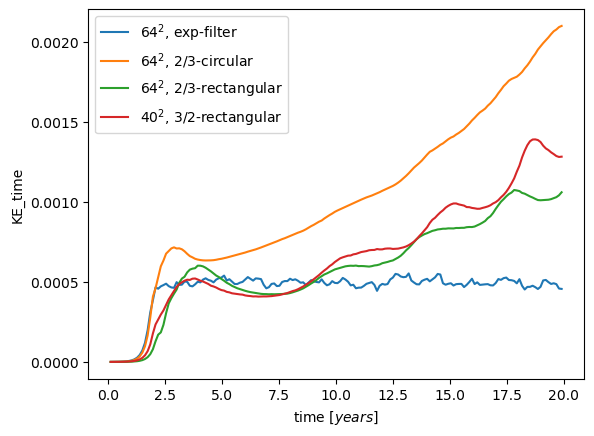

In [37]:
dataset_statistics(exp, averaging=False, truncate=False).KE_time.plot(label='$64^2$, exp-filter')
dataset_statistics(two_thirds_lazy, averaging=False, truncate=False).KE_time.plot(label='$64^2$, 2/3-circular')
dataset_statistics(two_thirds, averaging=False, truncate=False).KE_time.plot(label='$64^2$, 2/3-rectangular')
dataset_statistics(three_second_40, averaging=False, truncate=False).KE_time.plot(label='$40^2$, 3/2-rectangular')
plt.legend()

(0.0001, 1000.0)

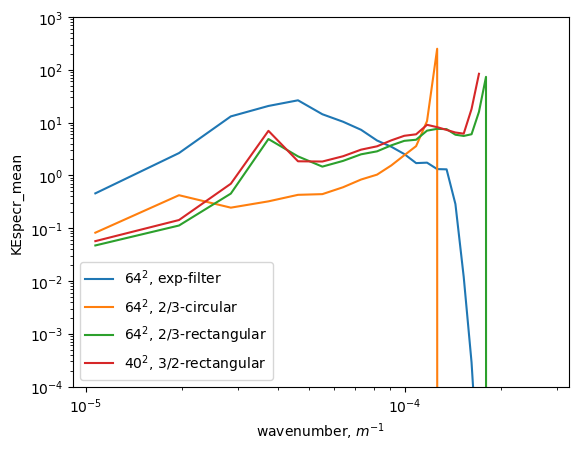

In [38]:
dataset_statistics(exp, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, exp-filter')
dataset_statistics(two_thirds_lazy, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, 2/3-circular')
dataset_statistics(two_thirds, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, 2/3-rectangular')
dataset_statistics(three_second_40, averaging=False, truncate=False).KEspecr_mean.plot(label='$40^2$, 3/2-rectangular')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-4,1e+3])

# Check subgrid forcing for 3/2-dealiasing

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
op5 = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator5-dealias-48/0.nc')
op1 = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/0.nc')

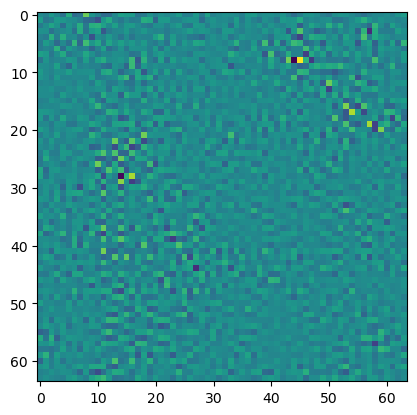

In [3]:
plt.imshow(op1.isel(time=-1, lev=0).q_forcing_advection)

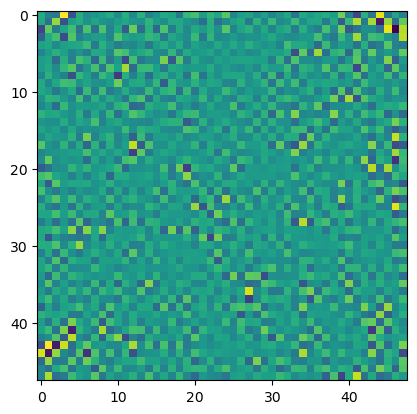

In [4]:
plt.imshow(op5.isel(time=-1, lev=0).q_forcing_advection)

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


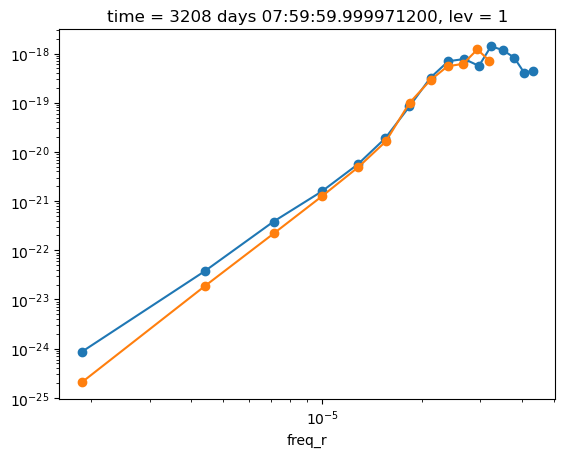

In [8]:
import xrft
sp(op1.isel(time=-10, lev=0).q_forcing_advection)
sp(op5.isel(time=-10, lev=0).q_forcing_advection)

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


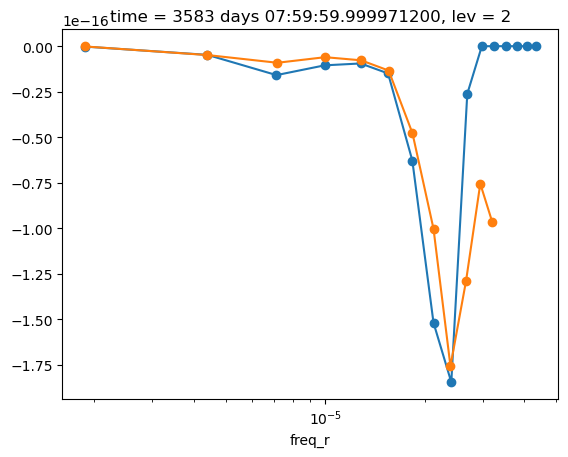

In [11]:
import numpy as np
idx = {'time': -1, 'lev': 1}
csp(op1.isel(**idx).q_forcing_advection, op1.isel(**idx).q)
csp(op5.isel(**idx).q_forcing_advection, op5.isel(**idx).q)

In [12]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator5-dealias-64/*.nc', combine='nested', concat_dim='run')